# Imports and program variables


In [35]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics
import pandas as pd

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint

from time_series_dataset_loader import TimeSeriesDatasetLoader

from sklearn.model_selection import train_test_split # to split dataset into train and test
from sklearn import preprocessing

In [2]:
DATASET_PATH = '../datasets/mfcc/'

## Setting up train and test datasets

In [3]:
dataset_loader = TimeSeriesDatasetLoader(DATASET_PATH)
X, y = dataset_loader.get_dataset()

In [4]:
X = np.asarray(X)
y = np.asarray(y)

In [23]:
# See X and y details
print(X[0][0])
print(X.shape)

print(y[:3])
print(y.shape)

[  0.         0.         3.718682  -6.211567  -6.517241  -1.706897
  13.20763   -5.951226  10.6546     2.279002   2.73413   -4.018963
   2.443366 -10.94868   -5.407908  -1.182022]
(2194, 96, 16)
[3 2 2]
(2194,)


In [17]:
# Split the dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

print("\nX_train:\n")
print(X_train[0][0])
print(X_train.shape)

print("\nX_test:\n")
print(X_test[0][0])
print(X_test.shape)

print("\ny_train:\n")
print(y_train[:3])
print(y_train.shape)

print("\ny_test:\n")
print(y_test[:3])
print(y_test.shape)


X_train:

[  0.           0.          10.12963      1.45358      2.464719
  -7.346106    -0.08271313   4.880109    -3.753943    -1.869719
  -0.2175865   -6.111303    -2.433165   -13.90869     -3.13206
  -6.74646   ]
(1535, 96, 16)

X_test:

[  0.          0.          6.233215   -1.078715   -3.127117   -6.422391
 -12.98617    10.00075   -12.99787    -7.946365   -8.501298   15.78257
  -1.560372    2.564178   -4.615028    0.7006073]
(659, 96, 16)

y_train:

[3 2 1]
(1535,)

y_test:

[5 3 2]
(659,)


In [26]:
# Create categorical matrices
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [38]:
num_rows = 96
num_columns = 16
num_channels = 1

X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

print("\nX_train:\n")
print(X_train[0][0])
print(X_train.shape)

print("\nX_test:\n")
print(X_test[0][0])
print(X_test.shape)


X_train:

[[  0.        ]
 [  0.        ]
 [ 10.12963   ]
 [  1.45358   ]
 [  2.464719  ]
 [ -7.346106  ]
 [ -0.08271313]
 [  4.880109  ]
 [ -3.753943  ]
 [ -1.869719  ]
 [ -0.2175865 ]
 [ -6.111303  ]
 [ -2.433165  ]
 [-13.90869   ]
 [ -3.13206   ]
 [ -6.74646   ]]
(1535, 96, 16, 1)

X_test:

[[  0.       ]
 [  0.       ]
 [  6.233215 ]
 [ -1.078715 ]
 [ -3.127117 ]
 [ -6.422391 ]
 [-12.98617  ]
 [ 10.00075  ]
 [-12.99787  ]
 [ -7.946365 ]
 [ -8.501298 ]
 [ 15.78257  ]
 [ -1.560372 ]
 [  2.564178 ]
 [ -4.615028 ]
 [  0.7006073]]
(659, 96, 16, 1)


## Building and Compiling Model

In [32]:
# Construct model 
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(7, activation='softmax'))

In [33]:
# # top-k category accuracy
# top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
# top3_acc.__name__ = 'top3_acc'

# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
# Define bath and epochs
batch_size = 16
epochs = 100

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.0000001)
mcp_save = ModelCheckpoint('../models/model_checkpoints/time_series.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, y_test), callbacks=[mcp_save, lr_reduce])

Train on 1535 samples, validate on 659 samples
Epoch 1/100
1535/1535 [==============================] - 2s 1ms/step - loss: 1.9601 - accuracy: 0.1720 - val_loss: 1.9371 - val_accuracy: 0.1351
Epoch 2/100
1535/1535 [==============================] - 2s 1ms/step - loss: 1.9346 - accuracy: 0.1687 - val_loss: 1.9307 - val_accuracy: 0.1745
Epoch 3/100
1535/1535 [==============================] - 2s 1ms/step - loss: 1.9145 - accuracy: 0.1948 - val_loss: 1.9075 - val_accuracy: 0.1745
Epoch 4/100
1535/1535 [==============================] - 2s 2ms/step - loss: 1.9026 - accuracy: 0.2163 - val_loss: 1.8882 - val_accuracy: 0.2246
Epoch 5/100
1535/1535 [==============================] - 2s 1ms/step - loss: 1.8718 - accuracy: 0.2208 - val_loss: 1.8663 - val_accuracy: 0.2367
Epoch 6/100
1535/1535 [==============================] - 2s 1ms/step - loss: 1.8559 - accuracy: 0.2391 - val_loss: 1.8474 - val_accuracy: 0.2534
Epoch 7/100
1535/1535 [==============================] - 2s 1ms/step - loss: 1.8485

Epoch 57/100
1535/1535 [==============================] - 2s 2ms/step - loss: 0.9660 - accuracy: 0.6443 - val_loss: 1.8172 - val_accuracy: 0.3111
Epoch 58/100
1535/1535 [==============================] - 2s 2ms/step - loss: 0.9535 - accuracy: 0.6384 - val_loss: 1.8642 - val_accuracy: 0.3171
Epoch 59/100
1535/1535 [==============================] - 2s 2ms/step - loss: 0.9426 - accuracy: 0.6697 - val_loss: 1.8901 - val_accuracy: 0.3096
Epoch 60/100
1535/1535 [==============================] - 2s 2ms/step - loss: 0.9174 - accuracy: 0.6723 - val_loss: 1.8395 - val_accuracy: 0.3141
Epoch 61/100
1535/1535 [==============================] - 3s 2ms/step - loss: 0.9033 - accuracy: 0.6723 - val_loss: 1.8806 - val_accuracy: 0.3141
Epoch 62/100
1535/1535 [==============================] - 2s 1ms/step - loss: 0.8688 - accuracy: 0.6840 - val_loss: 1.9826 - val_accuracy: 0.2974
Epoch 63/100
1535/1535 [==============================] - 2s 1ms/step - loss: 0.8688 - accuracy: 0.6853 - val_loss: 1.9113 -

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 95, 15, 32)        160       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 47, 7, 32)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 47, 7, 32)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 6, 64)         8256      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 3, 64)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 23, 3, 64)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 22, 2, 128)       

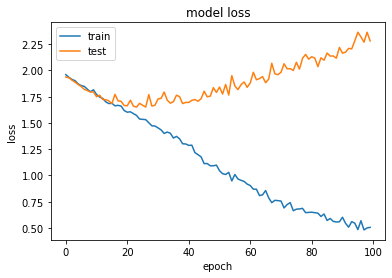

In [41]:
import matplotlib.pyplot as plt

# Model Summary

model.summary()

# PLT History info
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()